In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.gridspec import GridSpec
import matplotlib
import sys
import re
import os

from offsb.tools import const
import offsb.rdutil as rdutil

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

import pickle

PREFIX="."
HEADER_LEN=4

RDKit WARNING: [02:51:07] Enabling RDKit 2019.09.1 jupyter extensions


In [3]:
def gen_plot( QCA, fnm):
    try:
        d = np.loadtxt( fnm, usecols=(5,2,6), skiprows=3)
        if d.size == 0:
            return
    except StopIteration:
        print("No data for", fnm)
        return

    entry   = np.genfromtxt( fnm, usecols=(0,),  skip_header=HEADER_LEN, dtype=np.dtype("str"))[0]
    smiles  = np.genfromtxt( fnm, usecols=(7,),  skip_header=HEADER_LEN, dtype=np.dtype("str"), comments=None)[0]
    scanned = np.genfromtxt( fnm, usecols=( 4,), skip_header=HEADER_LEN, dtype=np.dtype("str"))[0]
    scanned = eval('[' + scanned.replace('-',',') + ']')
    scanned = [x+1 for x in scanned]
    #print(scanned)
    print( fnm, smiles)
    mol_id = np.genfromtxt( fnm, usecols=(1,), skip_header=HEADER_LEN, dtype=np.dtype("str"))

    with open( fnm, 'r') as fd:
        ds_name = fd.readline().strip("\n")
        method  = fd.readline().strip("\n")
        basis   = fd.readline().strip("\n")

    scan = d[:,0]
    qm_abs_min = d[:,1].min()
    qmene = d[:,1] * const.hartree2kcalmol
    qmene -= qmene.min()
    mmene = d[:,2] 
    mmene -= mmene.min()

    mm_min_pt = scan[ np.argsort(mmene)[0]]
    qm_min_pt = scan[ np.argsort(qmene)[0]]


    qcmol = QCA.db.get( mol_id[0]).get( "data")
    try:
        mol = rdutil.mol.build_from_smiles( smiles)
        molnoindex = rdutil.mol.build_from_smiles( re.sub(":[1-9][0-9]*", "", smiles))
    except Exception as e:
        print(e)
        return
    AllChem.ComputeGasteigerCharges( mol)
    totalcharge=0.0
    for i, atom in enumerate( mol.GetAtoms()):
        totalcharge += float( atom.GetProp('_GasteigerCharge'))
    atom_map = rdutil.mol.atom_map( mol)
    inv = {val:key for key,val in atom_map.items()}
    #print(atom_map)
    scanned = [inv[i] for i in scanned]
    #scanned = [rdutil.mol.atom_map_invert( atom_map)[i] for i in scanned]
    #print(scanned)
    molflat = rdutil.mol.build_from_smiles( smiles)
    try:
        ret = rdutil.mol.embed_qcmol_3d( mol, qcmol)
        #print("EMBED WAS RET:", ret)
        #AllChem.GenerateDepictionMatching3DStructure(molflat, mol)
        AllChem.Compute2DCoords(molnoindex)
    except Exception as e:
        print( "Could not generate conformation:")
        print( e)
        return
    options = DrawingOptions()
    options.atomLabelFontSize = 110
    options.atomLabelFontFace = "sans"
    options.dotsPerAngstrom = 400
    options.bondLineWidth = 8
    options.coordScale = 1
    png = Draw.MolToImage(
            molnoindex,
            highlightAtoms=scanned, 
            highlightColor=[0,.8,0],
            size=(500*12,500*4),
            fitImage=True,
            options=options)

    fig = plt.figure(figsize=(8,3.5), dpi=120, constrained_layout=True)
    matplotlib.rc("font", **{"size": 10})
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot( gs[:2,0])
    ax1.plot( scan, qmene, 'bo-', lw=1, ms=2, label="QM")
    ax1.plot( scan, mmene, 'ro-', lw=1, ms=2, label="MM")
    ax1.set_ylabel("Energy (kcal/mol)")
    ax1.set_xlabel("Scan value")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.legend(loc='best')
    ax2 = fig.add_subplot(gs[0,1])
    ax2.imshow(png)
    ax2.axis( 'off')
    ax3 = fig.add_subplot(gs[1,1])
    kwargs = { "fontsize" : 8, "fontname": "Monospace" }
    #ax3.text(.5,1.1,"{:^60s}".format(re.sub(":[1-9][0-9]*","",smiles)), fontsize=4, fontname="Monospace", ha='center')
    ax3.text(0,.9,"{:<16s}{:>39s}".format("QCA Dataset:", ds_name), **kwargs)
    ax3.text(0,.8,"{:<16s}{:>39s}".format("QCA Entry:", entry.split("-")[1]), **kwargs)
    ax3.text(0,.7,"{:<16s}{:>39s}".format("MM spec:", "Parsley unconstrained"), **kwargs)
    ax3.text(0,.6,"{:<16s}{:>39s}".format("MM charges:", "ANTECHAMBER AM1-BCC"), **kwargs)
    ax3.text(0,.5,"{:<16s}{:>39s}".format("Total charge", "{:6.2f}".format(totalcharge) ), **kwargs)
    ax3.text(0,.4,"{:<16s}{:>39s}".format("QM spec:", "{}/{}".format(method, basis)), **kwargs)
    ax3.text(0,.3,"{:<16s}{:>39s}".format("QM Absolute min:", "{:16.13e} au".format( qm_abs_min)), **kwargs)
    ax3.text(0,.2,"{:<16s}{:>39s}".format("QM Min point:", "{:8.2f}".format( qm_min_pt)), **kwargs)
    ax3.text(0,.1,"{:<16s}{:>39s}".format("MM Min point:", "{:8.2f}".format( mm_min_pt)), **kwargs)
    ax3.text(0,.0,"{:<16s}{:>39s}".format("OFFSB ver", "1.0"), **kwargs)
    ax3.axis('off')
    fig = None

    return

In [4]:
with open( os.path.join(PREFIX, 'QCA.p'), 'rb') as fid:
    QCA = pickle.load(fid)
    if QCA.db is None:
        with open( os.path.join( PREFIX, 'QCA.db.p'), 'rb') as fid:
            QCA.db = pickle.load(fid).db

./QCP-18045415.MMEnergyA.dat [H:9][C:2]([H:10])([c:1]1[n:4][n:5][n:6][n:7]1[H:13])[C:3]([H:11])([H:12])[Br:8]
./QCP-18045416.MMEnergyA.dat [H:10][C@:2]1([C:1]([O:6]1)([H:8])[H:9])[C:3]([H:11])([H:12])[C:4]([H:13])([H:14])[C:5]([H:15])([H:16])[F:7]
./QCP-18536017.MMEnergyA.dat [H:10][C@@:2]1([C:1]([O:6]1)([H:8])[H:9])[C:3]([H:11])([H:12])[C:4]([H:13])([H:14])[C:5]([H:15])([H:16])[F:7]
./QCP-18536018.MMEnergyA.dat [C@@:2]([C:1]([F:3])([F:4])[Br:7])([F:5])([Cl:6])[Br:8]


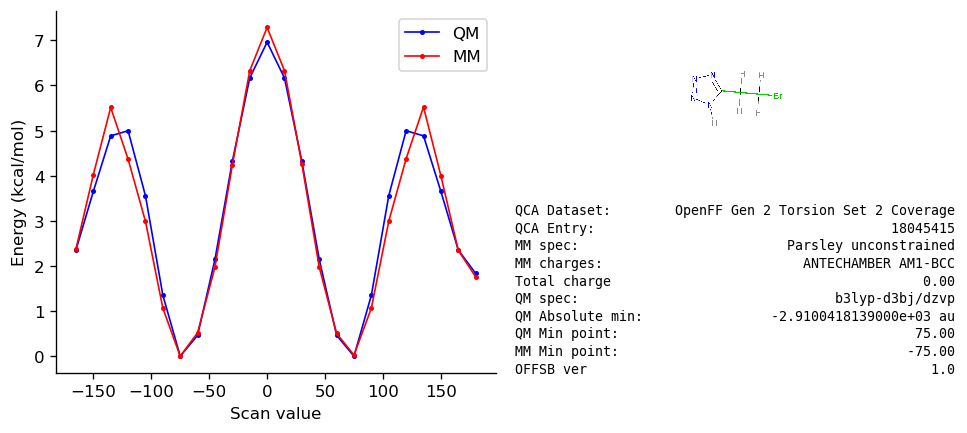

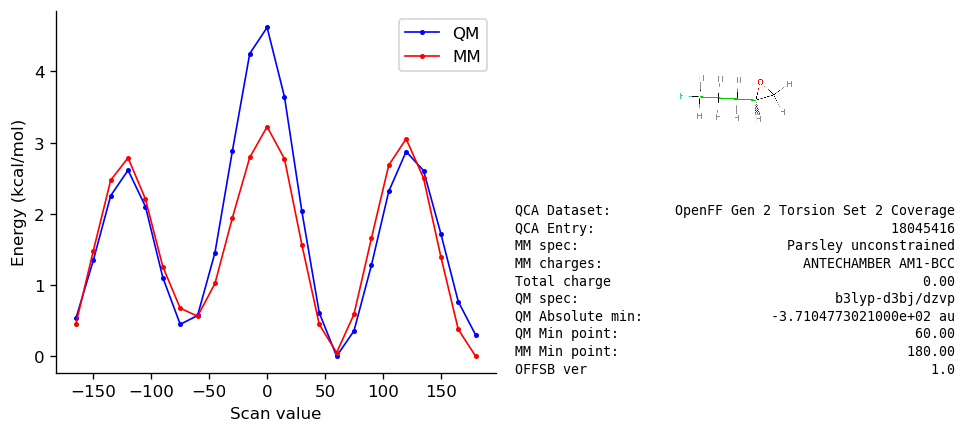

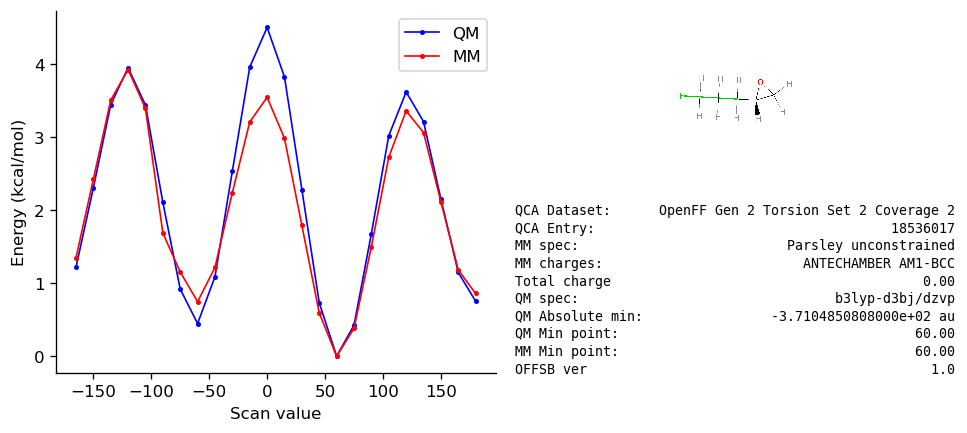

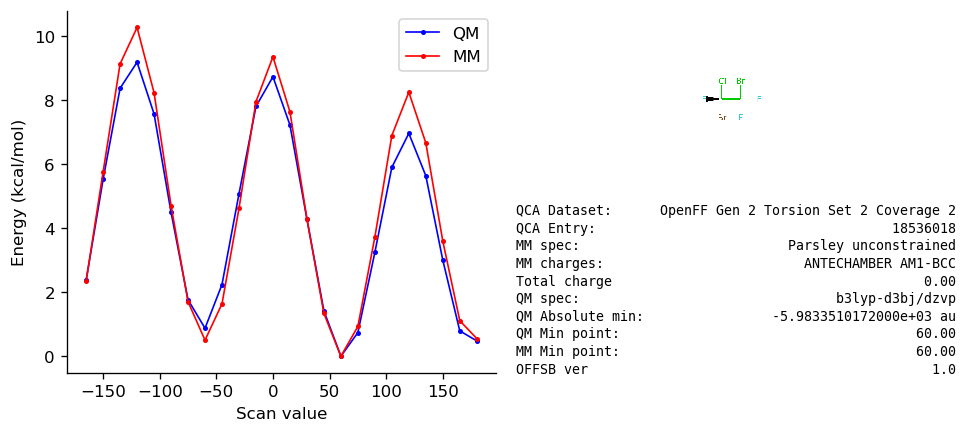

In [5]:
input_files = ["QCP-18045415.MMEnergyA.dat",
               "QCP-18045416.MMEnergyA.dat",
               "QCP-18536017.MMEnergyA.dat",
               "QCP-18536018.MMEnergyA.dat"]
for fnm in input_files:               
    gen_plot( QCA, os.path.join( PREFIX, fnm) )